# <span style="color:blue"> Herramientas y técnicas para analisis  de Tweets sobre el proyecto "Plan Integral de Movilidad en el sur de la Ciudad de la ZMG" </span>

## Contenido

+ Visualización de información georeferenciada
+ Extracción de tweets usando scraping (API Twitter)
* Preprocesamiento y análisis de texto
* Análisis de sentimiento 
* Herramientas de la libreria Scikit-Learn para modelado estadístico
* Comentarios finales

In [1]:
# Librerias a utilizar 
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import re
from matplotlib import style
plt.style.use('ggplot')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))
import altair as alt
import nltk
import spacy
from spacy import displacy

## 1. Visualización de información georeferenciada

Ante el incremento exponencial de población en la zona metropolitana de Guadalajara, tambíen se ha observado un aumento en la cantidad de vehículos en circulación durante los últimos años

In [2]:
import geopandas as gpd
#Ignorar los warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
shp_path = "/conjunto_de_datos/14mun.shp"
sf = gpd.read_file(shp_path, encoding = 'utf-8')
sf.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,14001,14,001,Acatic,"POLYGON ((2410828.699 985273.726, 2410924.473 ..."
1,14002,14,002,b'Acatl\xe1n de Ju\xe1rez',"POLYGON ((2328125.300 945179.633, 2328380.911 ..."
2,14003,14,003,Ahualulco de Mercado,"POLYGON ((2302732.801 979189.999, 2302796.799 ..."
3,14004,14,004,Amacueca,"POLYGON ((2331694.826 897026.370, 2331868.724 ..."
4,14005,14,005,b'Amatit\xe1n',"POLYGON ((2318919.000 991037.000, 2319056.299 ..."


In [4]:
# Agregamos al dataset la cantidad de vehículos en circulación durante el periodo 2010-2020 y la población de cada uno los municipios que integran la ZMG
zmg = (sf[(sf.CVE_MUN=='120') | (sf.CVE_MUN=='070') | (sf.CVE_MUN=='039') | (sf.CVE_MUN=='098') | (sf.CVE_MUN=='101') | (sf.CVE_MUN=='097')])

# Datos Obtenidos https://www.inegi.org.mx/app/tabulados/interactivos/?px=VMRC_2&bd=VMRC
zmg['Vehic_circ'] = [9946211, 31493, 1000559, 2916759, 1644722, 7395068] 
zmg['pob_tot'] = [1385629, 232852, 727750, 687127, 536111, 1476491]
zmg

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,Vehic_circ,pob_tot
38,14039,14,039,Guadalajara,"POLYGON ((2363989.299 972099.751, 2364144.238 ...",9946211,1385629
69,14070,14,070,El Salto,"POLYGON ((2363406.115 953068.615, 2363440.464 ...",31493,232852
96,14097,14,097,b'Tlajomulco de Z\xfa\xf1iga',"POLYGON ((2347115.993 955366.985, 2349344.486 ...",1000559,727750
97,14098,14,098,San Pedro Tlaquepaque,"POLYGON ((2363602.029 960533.482, 2363755.777 ...",2916759,687127
100,14101,14,101,b'Tonal\xe1',"POLYGON ((2369002.070 966925.392, 2369182.280 ...",1644722,536111
119,14120,14,120,Zapopan,"POLYGON ((2343267.753 998532.734, 2343338.637 ...",7395068,1476491


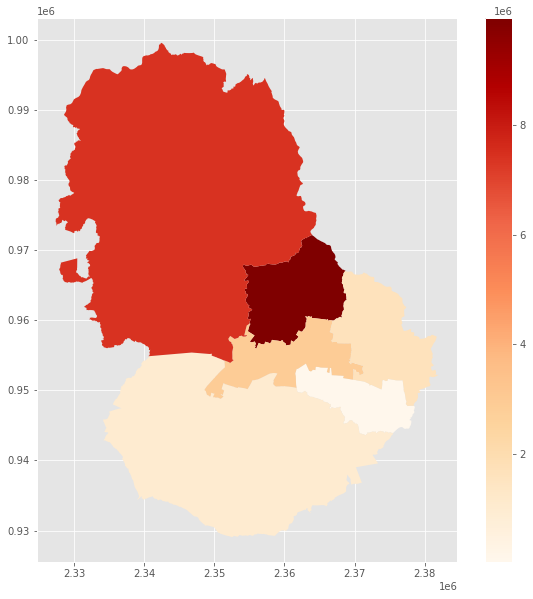

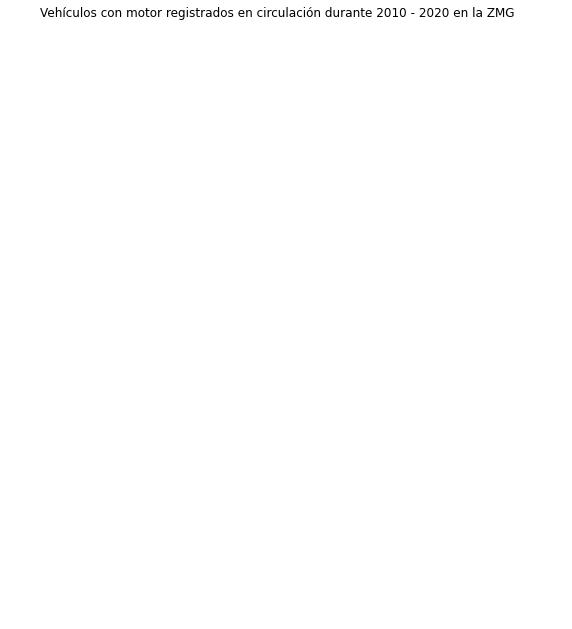

In [5]:
zmg.plot('Vehic_circ', figsize=(10,10), legend=True, cmap='OrRd')
fig , fila = plt.subplots(1, figsize=(10,10))
fig.suptitle("Vehículos con motor registrados en circulación durante 2010 - 2020 en la ZMG")
fila.set_axis_off()  
plt.show()

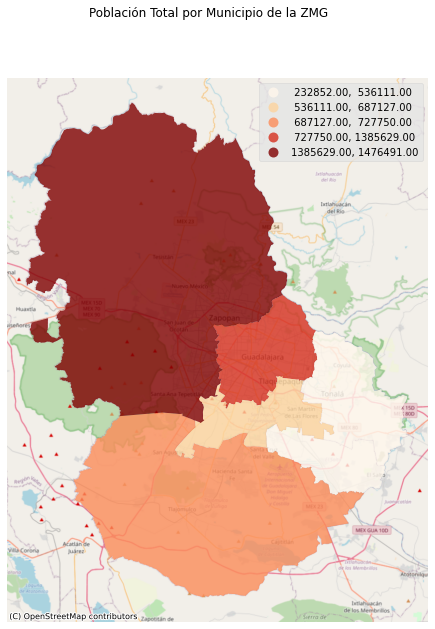

In [6]:
import contextily as ctx
fig , fila = plt.subplots(1, figsize=(10,10))
zmg.plot('pob_tot', figsize=(10,10), legend=True, cmap='OrRd', scheme='quantiles', ax=fila, alpha=0.8)
fig.suptitle("Población Total por Municipio de la ZMG")
fila.set_axis_off()
ctx.add_basemap(fila, source=ctx.providers.OpenStreetMap.Mapnik, crs=zmg.crs.to_string())
plt.show()

* Los municipios de Zapopan y Guadalajara son los que tienen la mayor cantidad de habitantes dentro de la ZMG
* Sin embargo Guadalajara presenta la mayor cantidad de vehículos en circulación durante estos últimos años y considerando que el área km2 es mucho menor a la de otros municipios
* Ante esto,surge el interés el proyecto de movilidad que implementará el Gobierno del Estado de Jalisco para mitigar el problema de caos vía en la ciudad ante un mayor crecimiento de personas y vehículos. 

## 2. Extracción de Tweets usando Scraping (API Twitter)

In [7]:
# Importamos los datos
os.chdir("/Semestre IV/DPII")
os.getcwd()
tweets = pd.read_csv("Plan_integral_movilidad.csv", sep=",")
tweets.head()

,Unnamed: 0,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
0,1,¿Ya vieron todo lo que incluye el Plan Integra...,False,0,#N/D,4/27/2023 20:14:13,True,#N/D,1651681174425858048,#N/D,"<a href=""http://www.socialbakers.com/"" rel=""no...",VeroDelgadilloG,0,False,False,#N/D,#N/D
1,2,RT @JorgeAldanaB: En nuestro compromiso por me...,False,0,#N/D,4/27/2023 20:11:35,False,#N/D,1651680513139044357,#N/D,"<a href=""https://mobile.twitter.com"" rel=""nofo...",DbcontrolI33590,27,True,False,#N/D,#N/D
2,3,"RT @quierotv_gdl: ""Solución López Mateos"" \n??...",False,0,#N/D,4/27/2023 16:29:05,False,#N/D,1651624516576067589,#N/D,"<a href=""https://mobile.twitter.com"" rel=""nofo...",LiborioRG,1,True,False,#N/D,#N/D
3,4,"""Solución López Mateos"" \n?? Conoce la estrate...",False,1,#N/D,4/27/2023 16:22:36,True,#N/D,1651622886539403264,#N/D,"<a href=""https://mobile.twitter.com"" rel=""nofo...",quierotv_gdl,1,False,False,#N/D,#N/D
4,5,RT @PpopularElche: Proponemos un Plan de Movil...,False,0,#N/D,4/27/2023 16:04:09,False,#N/D,1651618245529485317,#N/D,"<a href=""http://twitter.com/download/android"" ...",Eduardo65539796,7,True,False,#N/D,#N/D


La importación de tweets fue através de la libreria **twitterR** en el lenguaje de programación R por medio de las claves de acceso a la API de Twitter.
  
  Se descargaron 1735 tweets relacionados al tema, con la intención de obtener la percepción de la ciudadanía jaliscience sobre el proyecto en marcha.

In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     1735 non-null   int64 
 1   text           1735 non-null   object
 2   favorited      1735 non-null   bool  
 3   favoriteCount  1735 non-null   int64 
 4   replyToSN      1735 non-null   object
 5   created        1735 non-null   object
 6   truncated      1735 non-null   bool  
 7   replyToSID     1735 non-null   object
 8   id             1735 non-null   int64 
 9   replyToUID     1735 non-null   object
 10  statusSource   1735 non-null   object
 11  screenName     1735 non-null   object
 12  retweetCount   1735 non-null   int64 
 13  isRetweet      1735 non-null   bool  
 14  retweeted      1735 non-null   bool  
 15  longitude      1735 non-null   object
 16  latitude       1735 non-null   object
dtypes: bool(4), int64(4), object(9)
memory usage: 183.1+ KB


## 3. Preprocesamiento y análisis de texto

In [9]:
#Dataframe con los tweets como texto
text_tweets = pd.DataFrame(tweets['text'])
text_tweets.head()

,text
0,¿Ya vieron todo lo que incluye el Plan Integra...
1,RT @JorgeAldanaB: En nuestro compromiso por me...
2,"RT @quierotv_gdl: ""Solución López Mateos"" \n??..."
3,"""Solución López Mateos"" \n?? Conoce la estrate..."
4,RT @PpopularElche: Proponemos un Plan de Movil...


In [10]:
#Realizamos limpieza de información en el texto de los tweets
def limpiar_texto(text):
    text = text.lower() 
    text = re.sub(r'@[A-Za-z09]+','',text)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'rt[\s]+','',text)
    text = re.sub(r'https:\/\/?','',text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtro_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtro_text)
    

In [11]:
text_tweets['text'] = text_tweets['text'].apply(limpiar_texto)
text_tweets.head()

,text
0,vieron incluye plan integral movilidad present...
1,compromiso mejorar movilidad capital realizado...
2,_gdl solución lópez mateos conoce estrategia m...
3,solución lópez mateos conoce estrategia movili...
4,proponemos plan movilidad integral municipal c...


Ahora cada uno de los tweets se encuentra limpios de signos de puntuación, @, signos de hashtags, enlances, entre otros que no pueden llegar a servir para el análisis.

In [12]:
text_tweets = text_tweets.drop_duplicates('text')
text_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 0 to 1734
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    716 non-null    object
dtypes: object(1)
memory usage: 11.2+ KB


Eliminamos textos duplicados para quedarnos debido a que la mayoría son retweets.
  
El dataset se queda con 716 registros de los 1735 que fueron extraídos por el scraping en la API

In [13]:
stemmer= PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [14]:
text_tweets['text'] = text_tweets['text'].apply(lambda x: stemming(x))
text_tweets.head()

,text
0,vieron incluye plan integral movilidad present...
1,compromiso mejorar movilidad capital realizado...
2,_gdl solución lópez mateos conoce estrategia m...
3,solución lópez mateos conoce estrategia movili...
4,proponemos plan movilidad integral municipal c...


Stemming es una técnica de normalización de texto en el procesamiento del lenguaje natural que reduce las palabras a su raíz. 
 
 La técnica de stemming elimina los afijos de las palabras lo que puede generar palabras no válidas.

In [15]:
import es_core_news_sm
nlp = es_core_news_sm.load()

In [16]:
def spacy_analyzer(text):
    doc = nlp(text)
    return doc

In [17]:
doc = text_tweets['text'].apply(spacy_analyzer)
text_tweets['Document'] = text_tweets['text'].apply(spacy_analyzer)
doc

0       (vieron, incluye, plan, integral, movilidad, p...
1       (compromiso, mejorar, movilidad, capital, real...
2       (_, gdl, solución, lópez, mateos, conoce, estr...
3       (solución, lópez, mateos, conoce, estrategia, ...
4       (proponemos, plan, movilidad, integral, munici...
                              ...                        
1729    (gobierno, macuspana, secretaría, ordenamiento...
1730    (cali, hará, parte, creación, primera, área, m...
1732    (cali, hará, parte, creación, primera, área, m...
1733    (proyectos, renovación, infraestructura, públi...
1734    (proyectos, renovación, infraestructura, públi...
Name: text, Length: 716, dtype: object

In [18]:
#Extracción de entidades nombradas (NER)
def extract_entities(text):
    doc = nlp(text)
    entities = []
    for entity in doc.ents:
        entities.append((entity.text, entity.label_))
    return entities
ent_nom = text_tweets['text'].apply(extract_entities)
text_tweets['Entidades'] = text_tweets['text'].apply(extract_entities)
ent_nom

0                                        []
1                      [(compromiso, MISC)]
2                                        []
3                     [(lópez mateos, PER)]
4       [(bicielx pedanías incorpora, PER)]
                       ...                 
1729                                     []
1730                          [(cali, LOC)]
1732                          [(cali, LOC)]
1733                                     []
1734                                     []
Name: text, Length: 716, dtype: object

In [19]:
##Análisis del tipo de la sintaxis de las palabras de los tweets
def analyze_syntax(text):
    doc = nlp(text)
    return [(token.text, token.pos_, token.dep_, token.head.text) for token in doc]

text_sintactico = text_tweets['text'].apply(analyze_syntax)
text_tweets['Sintaxis'] = text_tweets['text'].apply(analyze_syntax)
text_sintactico

0       [(vieron, VERB, csubj, incluye), (incluye, VER...
1       [(compromiso, NOUN, ROOT, compromiso), (mejora...
2       [(_, ADJ, ROOT, _), (gdl, PROPN, obl, lópez), ...
3       [(solución, NOUN, nsubj, lópez), (lópez, VERB,...
4       [(proponemos, VERB, ROOT, proponemos), (plan, ...
                              ...                        
1729    [(gobierno, PROPN, nsubj, secretaría), (macusp...
1730    [(cali, PROPN, nsubj, hará), (hará, VERB, ROOT...
1732    [(cali, PROPN, nsubj, hará), (hará, VERB, ROOT...
1733    [(proyectos, NOUN, nsubj, realiza), (renovació...
1734    [(proyectos, NOUN, nsubj, realiza), (renovació...
Name: text, Length: 716, dtype: object

In [20]:
#Análisis detallado del texto 
def analyze_dependencies(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

text_tweets['dependencias'] = text_tweets['text'].apply(analyze_dependencies)

In [21]:
#Lematización de las palabras para encontrar la palabra 
def lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

text_tweets['lemmas'] = text_tweets['text'].apply(lemmatize)
text_tweets['lemmas']

0       [ver, incluir, plan, integral, movilidad, pres...
1       [compromiso, mejorar, movilidad, capital, real...
2       [_, gdl, solución, lópez, mateos, conocer, est...
3       [solución, lópez, mateos, conocer, estrategia,...
4       [proponer, plan, movilidad, integral, municipa...
                              ...                        
1729    [gobierno, macuspán, secretacer, ordenamiento,...
1730    [cali, hacer, parte, creación, primero, área, ...
1732    [cali, hacer, parte, creación, primero, área, ...
1733    [proyecto, renovación, infraestructuro, públic...
1734    [proyecto, renovación, infraestructuro, públic...
Name: lemmas, Length: 716, dtype: object

In [22]:
#División de los tweets en frases
text_tweets['frases'] = text_tweets['text'].apply(lambda x: [sent.text for sent in nlp(x).sents])
text_tweets['frases'] 

0       [vieron incluye plan integral movilidad presen...
1       [compromiso mejorar movilidad capital realizad...
2       [_, gdl solución lópez mateos conoce estrategi...
3       [solución lópez mateos conoce estrategia movil...
4       [proponemos plan movilidad integral municipal ...
                              ...                        
1729    [gobierno macuspana secretaría ordenamiento te...
1730    [cali hará parte creación primera área metropo...
1732    [cali hará parte creación primera área metropo...
1733    [proyectos renovación infraestructura pública ...
1734    [proyectos renovación infraestructura pública ...
Name: frases, Length: 716, dtype: object

In [23]:
def recognize_idioms(text):
    doc = nlp(text)
    idioms = []
    for token in doc:
        if token.dep_ == 'compound' and token.head.pos_ == 'NOUN' and token.head.dep_ == 'dobj':
            idioms.append(token.text + ' ' + token.head.text)
    return idioms

text_tweets['idiomas'] = text_tweets['text'].apply(recognize_idioms)
text_tweets['idiomas']

0       []
1       []
2       []
3       []
4       []
        ..
1729    []
1730    []
1732    []
1733    []
1734    []
Name: idiomas, Length: 716, dtype: object

In [24]:
text_tweets

,text,Document,Entidades,Sintaxis,dependencias,lemmas,frases,idiomas
0,vieron incluye plan integral movilidad present...,"(vieron, incluye, plan, integral, movilidad, p...",[],"[(vieron, VERB, csubj, incluye), (incluye, VER...","[(vieron, csubj, incluye), (incluye, ROOT, inc...","[ver, incluir, plan, integral, movilidad, pres...",[vieron incluye plan integral movilidad presen...,[]
1,compromiso mejorar movilidad capital realizado...,"(compromiso, mejorar, movilidad, capital, real...","[(compromiso, MISC)]","[(compromiso, NOUN, ROOT, compromiso), (mejora...","[(compromiso, ROOT, compromiso), (mejorar, acl...","[compromiso, mejorar, movilidad, capital, real...",[compromiso mejorar movilidad capital realizad...,[]
2,_gdl solución lópez mateos conoce estrategia m...,"(_, gdl, solución, lópez, mateos, conoce, estr...",[],"[(_, ADJ, ROOT, _), (gdl, PROPN, obl, lópez), ...","[(_, ROOT, _), (gdl, obl, lópez), (solución, n...","[_, gdl, solución, lópez, mateos, conocer, est...","[_, gdl solución lópez mateos conoce estrategi...",[]
3,solución lópez mateos conoce estrategia movili...,"(solución, lópez, mateos, conoce, estrategia, ...","[(lópez mateos, PER)]","[(solución, NOUN, nsubj, lópez), (lópez, VERB,...","[(solución, nsubj, lópez), (lópez, ROOT, lópez...","[solución, lópez, mateos, conocer, estrategia,...",[solución lópez mateos conoce estrategia movil...,[]
4,proponemos plan movilidad integral municipal c...,"(proponemos, plan, movilidad, integral, munici...","[(bicielx pedanías incorpora, PER)]","[(proponemos, VERB, ROOT, proponemos), (plan, ...","[(proponemos, ROOT, proponemos), (plan, obj, p...","[proponer, plan, movilidad, integral, municipa...",[proponemos plan movilidad integral municipal ...,[]
...,...,...,...,...,...,...,...,...
1729,gobierno macuspana secretaría ordenamiento ter...,"(gobierno, macuspana, secretaría, ordenamiento...",[],"[(gobierno, PROPN, nsubj, secretaría), (macusp...","[(gobierno, nsubj, secretaría), (macuspana, am...","[gobierno, macuspán, secretacer, ordenamiento,...",[gobierno macuspana secretaría ordenamiento te...,[]
1730,cali hará parte creación primera área metropol...,"(cali, hará, parte, creación, primera, área, m...","[(cali, LOC)]","[(cali, PROPN, nsubj, hará), (hará, VERB, ROOT...","[(cali, nsubj, hará), (hará, ROOT, hará), (par...","[cali, hacer, parte, creación, primero, área, ...",[cali hará parte creación primera área metropo...,[]
1732,cali hará parte creación primera área metropol...,"(cali, hará, parte, creación, primera, área, m...","[(cali, LOC)]","[(cali, PROPN, nsubj, hará), (hará, VERB, ROOT...","[(cali, nsubj, hará), (hará, ROOT, hará), (par...","[cali, hacer, parte, creación, primero, área, ...",[cali hará parte creación primera área metropo...,[]
1733,proyectos renovación infraestructura pública _...,"(proyectos, renovación, infraestructura, públi...",[],"[(proyectos, NOUN, nsubj, realiza), (renovació...","[(proyectos, nsubj, realiza), (renovación, amo...","[proyecto, renovación, infraestructuro, públic...",[proyectos renovación infraestructura pública ...,[]


La práctica de limpiar y preparar los datos de texto es con el métoo de una obtener una mejor representación que sea l○ más rica semánticamente ○ menos ambigua y por lo tanto nos facilitará realizar el análisis de sentimiento y clasificación de Tweets sobre la percepción ciudadana acerca del proyecto.

## 4. Análisis de Sentimientos

**El análisis de sentimiento es esencialmente un algoritmo de clasificación que tiene como objetivo descubrir puntos de vista basados en opiniones, emociones relacionadas e información que puede ser de particular interés.**

Pero, desde la perspectiva de los datos, existe mucho más en las opiniones. Si bien es una evaluación subjetiva basada en experiencias personales, se corresponde con las emociones: un conjunto de significantes presenta un punto de vista complejo de experiencias y emociones. Con este entendimiento, el análisis de sentimiento puede:

 * Extraer datos de sentimiento en una plataforma específica, como un sitio de revisión o un servicio de atención al cliente
 * Determinar la polaridad positiva o negativa
 * Definir si se habla del tema en general o específicamente
 * Identificar a los portadores de opinión individualmente o en el contexto de los segmentos de audiencia existentes

In [25]:
#Obtener la subjetividad y polaridad de los tweets
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [26]:
text_tweets['Subjetividad'] = text_tweets['text'].apply(get_subjectivity)
text_tweets['Polaridad'] = text_tweets['text'].apply(get_polarity)
text_tweets.head()

,text,Document,Entidades,Sintaxis,dependencias,lemmas,frases,idiomas,Subjetividad,Polaridad
0,vieron incluye plan integral movilidad present...,"(vieron, incluye, plan, integral, movilidad, p...",[],"[(vieron, VERB, csubj, incluye), (incluye, VER...","[(vieron, csubj, incluye), (incluye, ROOT, inc...","[ver, incluir, plan, integral, movilidad, pres...",[vieron incluye plan integral movilidad presen...,[],0.0,0.0
1,compromiso mejorar movilidad capital realizado...,"(compromiso, mejorar, movilidad, capital, real...","[(compromiso, MISC)]","[(compromiso, NOUN, ROOT, compromiso), (mejora...","[(compromiso, ROOT, compromiso), (mejorar, acl...","[compromiso, mejorar, movilidad, capital, real...",[compromiso mejorar movilidad capital realizad...,[],0.0,0.0
2,_gdl solución lópez mateos conoce estrategia m...,"(_, gdl, solución, lópez, mateos, conoce, estr...",[],"[(_, ADJ, ROOT, _), (gdl, PROPN, obl, lópez), ...","[(_, ROOT, _), (gdl, obl, lópez), (solución, n...","[_, gdl, solución, lópez, mateos, conocer, est...","[_, gdl solución lópez mateos conoce estrategi...",[],0.0,0.0
3,solución lópez mateos conoce estrategia movili...,"(solución, lópez, mateos, conoce, estrategia, ...","[(lópez mateos, PER)]","[(solución, NOUN, nsubj, lópez), (lópez, VERB,...","[(solución, nsubj, lópez), (lópez, ROOT, lópez...","[solución, lópez, mateos, conocer, estrategia,...",[solución lópez mateos conoce estrategia movil...,[],0.0,0.0
4,proponemos plan movilidad integral municipal c...,"(proponemos, plan, movilidad, integral, munici...","[(bicielx pedanías incorpora, PER)]","[(proponemos, VERB, ROOT, proponemos), (plan, ...","[(proponemos, ROOT, proponemos), (plan, obj, p...","[proponer, plan, movilidad, integral, municipa...",[proponemos plan movilidad integral municipal ...,[],0.0,0.0


In [27]:
def sentimiento(score):
    if score < 0:
        return "Negativo"
    elif score == 0:
        return "Neutral"
    else:
        return "Positivo"

text_tweets["Sentimiento"] = text_tweets['Polaridad'].apply(sentimiento)
text_tweets.head()

,text,Document,Entidades,Sintaxis,dependencias,lemmas,frases,idiomas,Subjetividad,Polaridad,Sentimiento
0,vieron incluye plan integral movilidad present...,"(vieron, incluye, plan, integral, movilidad, p...",[],"[(vieron, VERB, csubj, incluye), (incluye, VER...","[(vieron, csubj, incluye), (incluye, ROOT, inc...","[ver, incluir, plan, integral, movilidad, pres...",[vieron incluye plan integral movilidad presen...,[],0.0,0.0,Neutral
1,compromiso mejorar movilidad capital realizado...,"(compromiso, mejorar, movilidad, capital, real...","[(compromiso, MISC)]","[(compromiso, NOUN, ROOT, compromiso), (mejora...","[(compromiso, ROOT, compromiso), (mejorar, acl...","[compromiso, mejorar, movilidad, capital, real...",[compromiso mejorar movilidad capital realizad...,[],0.0,0.0,Neutral
2,_gdl solución lópez mateos conoce estrategia m...,"(_, gdl, solución, lópez, mateos, conoce, estr...",[],"[(_, ADJ, ROOT, _), (gdl, PROPN, obl, lópez), ...","[(_, ROOT, _), (gdl, obl, lópez), (solución, n...","[_, gdl, solución, lópez, mateos, conocer, est...","[_, gdl solución lópez mateos conoce estrategi...",[],0.0,0.0,Neutral
3,solución lópez mateos conoce estrategia movili...,"(solución, lópez, mateos, conoce, estrategia, ...","[(lópez mateos, PER)]","[(solución, NOUN, nsubj, lópez), (lópez, VERB,...","[(solución, nsubj, lópez), (lópez, ROOT, lópez...","[solución, lópez, mateos, conocer, estrategia,...",[solución lópez mateos conoce estrategia movil...,[],0.0,0.0,Neutral
4,proponemos plan movilidad integral municipal c...,"(proponemos, plan, movilidad, integral, munici...","[(bicielx pedanías incorpora, PER)]","[(proponemos, VERB, ROOT, proponemos), (plan, ...","[(proponemos, ROOT, proponemos), (plan, obj, p...","[proponer, plan, movilidad, integral, municipa...",[proponemos plan movilidad integral municipal ...,[],0.0,0.0,Neutral


Los textos son clasificados con base a su polaridad de sentimiento, tomando uno de entre tres valores posibles: positivo, negativo, neutro (este entendido como textos que incluyen sentimientos positivos y negativos simultaneamente) o con ausencia de sentimiento. 

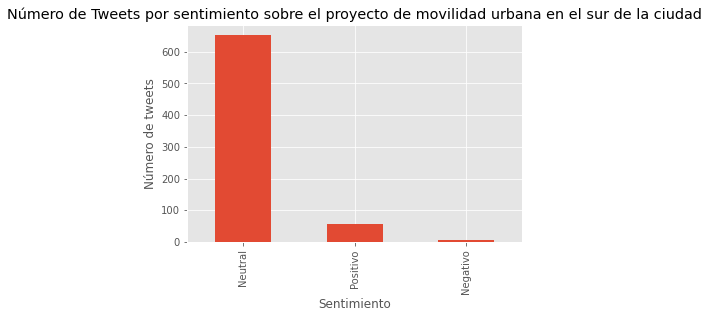

In [28]:
text_tweets['Sentimiento'].value_counts()

plt.title("Número de Tweets por sentimiento sobre el proyecto de movilidad urbana en el sur de la ciudad")
plt.xlabel('Sentimento')
plt.ylabel('Número de tweets')
text_tweets['Sentimiento'].value_counts().plot(kind='bar')
plt.show()

La mayoria son tweets neutrales; esto puede deberse a que la mayoria de las librerias manejan únicamente palabras en ingles y no se reconozcan algunas palabras en español. 
Otra de las limitaciones se puede deber al  periodo de recoleción de tweets fueron opiniones de medios de comunicación dando pie a un comentario neutral y no subjetivo

Text(0.5, 1.0, 'Distribución % del sentimiento en los tweets')

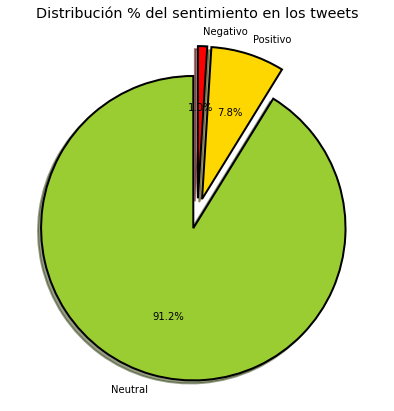

In [29]:
fig = plt.figure(figsize=(7,7))
colores = ("yellowgreen", "gold", "red")
wp = {'linewidth': 2, 'edgecolor': "black"}
tags = text_tweets['Sentimiento'].value_counts()
explode= (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow = True, colors=colores,
         startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title('Distribución % del sentimiento en los tweets')

Nos interesa conocer los tweets clasificados como positivos y negativos para analizar la aprobación del proyecto.

In [30]:
def sentimiento(score):
    if score < 0:
        return "Negativo"
    elif score > 0:
        return "Positivo"

text_tweets["Sentimiento"] = text_tweets['Polaridad'].apply(sentimiento)


In [31]:
tipo_sentimiento = text_tweets.groupby(['Sentimiento']).size().reset_index(name='frecuencia')
tipo_sentimiento

,Sentimiento,frecuencia
0,Negativo,7
1,Positivo,56


In [32]:
# Gráfica autodescriptiva: 
alt.Chart(tipo_sentimiento).mark_bar().encode(
    alt.X("Sentimiento:N", sort= '-y',title="Sentimiento del Tweet", bin=False),
    alt.Y('frecuencia:Q', title="Número de Tweets"),
    alt.Color('Sentimiento', legend=None)
).properties(width=alt.Step(150),
    title="Número de tweets pos sentimiento sobre el Proyecto"
)

alt.Chart(...)

Observamos que descartando los tweets neutrales, es mayor la cantidad de tweet positivos sobre los negativos sobre la idea del proyecto de movilidad en la ciudad.

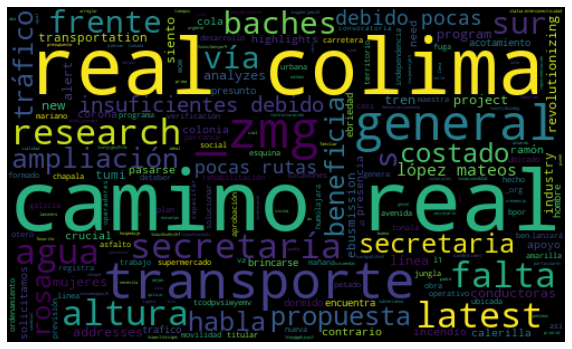

In [33]:
tweets_positivos = text_tweets[text_tweets.Sentimiento == 'Positivo']
tweets_positivos = tweets_positivos.sort_values(['Polaridad'], ascending=False)

# palabras mas frecuentes de los comentarios positivos
text1 = ' '.join([word for word in tweets_positivos['text']])
plt.figure(figsize=(10,10),facecolor="None")
wordcloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(text1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Las palabras con mayor frecuencia en los comentarios positivos son: camino a real colima, transporte, altura, secretaria, beneficia, ampliación, entre otras.

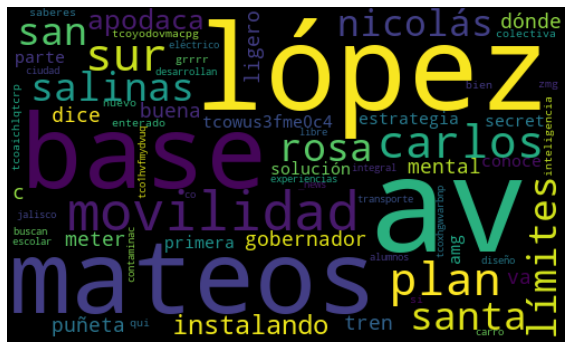

In [34]:
tweets_negativos = text_tweets[text_tweets.Sentimiento == 'Negativo']
tweets_negativos = tweets_negativos.sort_values(['Polaridad'], ascending=False)
# palabras mas frecuentes de los comentarios negativos
text2 = ' '.join([word for word in tweets_negativos['text']])
plt.figure(figsize=(10,10),facecolor="None")
wordcloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(text2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Las palabras con magor frecuencia en los comentarios negativos son:  avenida lopez mateos, movilidad, gobernador, tren limites, entre otros.

In [36]:
def sentimiento(score):
    if score < 0:
        return "Negativo"
    elif score == 0:
        return "Neutral"
    else:
        return "Positivo"

text_tweets["Sentimiento"] = text_tweets['Polaridad'].apply(sentimiento)

## 5. Herramientas de la libreria Scikit-Learn para modelado estadístico

Convertir una colección de documentos de texto en una matriz de recuentos de tokens.
Se usará la validación cruzada, para verificar la precisión de los modelos supervisados para estre trabajo; Regresión Logistica y Suport Vector Machine

In [37]:
## Analisis con sklearn
vector = CountVectorizer(ngram_range = (1,2)).fit(text_tweets['text'])

In [38]:
# Selección de caracteristicas
feature_names = vector.get_feature_names_out()

In [39]:
X = text_tweets['text']
Y = text_tweets['Sentimiento']
X = vector.transform(X)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [41]:
print("Tamaño de x_train:", (x_train.shape))
print("Tamaño de x_test:", (x_test.shape))
print("Tamaño de y_train:", (y_train.shape))
print("Tamaño de y_test:", (y_test.shape))

Tamaño de x_train: (572, 6532)
Tamaño de x_test: (144, 6532)
Tamaño de y_train: (572,)
Tamaño de y_test: (144,)


La regresión logística es una técnica de aprendizaje automático empleada en
la tarea de clasificación. Se trata de un algoritmo simple que permite interpretar 
fácilmente los resultados obtenidos a partir de la función logística. 
  
Los resultados que se obtienen con este modelo son valores probabilísticos entre cero y uno
los cuales, mediante un valor umbral, se asignan a una clase u otra.

In [42]:
mod_logreg = LogisticRegression()
mod_logreg.fit(x_train, y_train)
mod_logreg_pred = mod_logreg.predict(x_test)
mod_logreg_acc = accuracy_score(mod_logreg_pred, y_test)
print("Test de Precisión: {:.2f}%".format(mod_logreg_acc*100))

Test de Precisión: 97.92%


Realizar una predicción del modelo usando una regresión logística es del 97.92%, el modelo indica una buena precisión de predicción

In [43]:
print(confusion_matrix(y_test, mod_logreg_pred))
print("\n")
print(classification_report(y_test,mod_logreg_pred))

[[  0   2   0]
 [  0 137   0]
 [  0   1   4]]


              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         2
     Neutral       0.98      1.00      0.99       137
    Positivo       1.00      0.80      0.89         5

    accuracy                           0.98       144
   macro avg       0.66      0.60      0.63       144
weighted avg       0.97      0.98      0.97       144



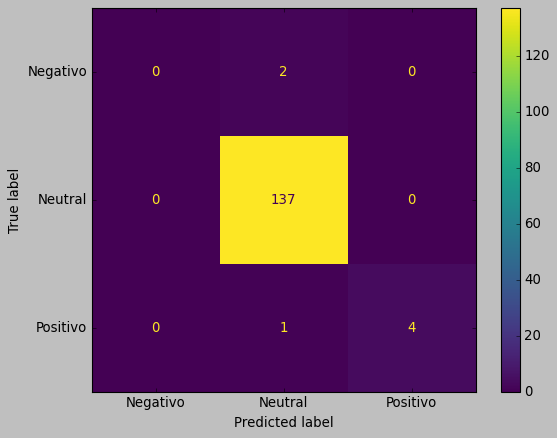

In [44]:
style.use('classic')
cm = confusion_matrix(y_test, mod_logreg_pred, labels=mod_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=mod_logreg.classes_)
disp.plot()

El modelo predijo 4 tweets positivos y fueron 4 postivos y el mismo caso para los tweets neutrales, es decir, de 137 que predijo el modelo los 137 fueron etiquetados como neutrales. Puede ser un buen modelo para predecir cualquier otro tipo de Tweet y con más información

El tiempo de ajuste escala al menos cuadráticamente con el número de muestras y puede no ser práctico más allá de decenas de miles de muestras. Para grandes conjuntos de datos, considere usar LinearSVC o SGDClassifier en su lugar, posiblemente después de un transformador Nystroem u otra aproximación de kernel.

In [45]:
from sklearn.svm import LinearSVC

In [46]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [47]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test de precicion: {:.2f}%".format(svc_acc*100))

test de precicion: 97.92%


In [48]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test,svc_pred))

[[  0   2   0]
 [  0 137   0]
 [  0   1   4]]


              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         2
     Neutral       0.98      1.00      0.99       137
    Positivo       1.00      0.80      0.89         5

    accuracy                           0.98       144
   macro avg       0.66      0.60      0.63       144
weighted avg       0.97      0.98      0.97       144



Con este modelo de precisión general se obtiene el 97.92%.
Aspi mismo obtiene los mismos indicadores de validacion cruzada que el modelo de regresión logistica

## 6. Comentarios Finales

El presente trabajo tuvo como objetivo poner en práctica las herramientas, métodos y técnicas utilizadas para realizar análisis en los Tweets; Con la idea de identificar puntos importantes y percepciones que tienen las personas sobre el proyecto que implementará el Gobierno del Estado de Jalisco para mejorar la movilidad vial y urbana en la ciudad ante un constante y frecuente congestionamiento que no permite llegar a los ciudadanos a su destino.
Se presentan los siguientes resultados finales:
* Guadalajara al tener una población menor y una área (km2) menor a la de Zapopan presenta una mayor concentración de vehículos registrados en circulación durante el período 2010 - 2020.
* Fueron 1735 tweets obtenidos de la API de Twitter a través de Scraping
* De la muestra obtenida se obtuvieron más tweets positivos que negativos sobre el proyecto
* Las palabras con mayor frecuencia en los tweets positivos por mencionar algunas: propuesta, real Colima, ampliación. Las cuales serán medidad que ayuden o aporten a la movilidad en la ciudad ante un creciente aumento de vehículos y personas.
* Las palabras con mayor frecuencia en los tweets negativos fueron: Lopez Mateos, gobernador, límites, movilidad, entre otras. Esto ante la situación actual de la avenida que los usuarios llegan a quejarse día a día del trafico intenso.
* Se arrojo una precisión general del modelo de regresión logística y Support Vector Machin del 97.92% (teniendo un buen modelo para clasificar los siguientes tweets en positivos o negativos).
 